In [21]:
%pip install -q torch torchvision higher

import os
import random
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import higher

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [23]:
dataset_path = r"D:\data\Digits"

full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))
class FewShotTask:
    def __init__(self, dataset, num_classes, num_support, num_query):
        self.dataset = dataset
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.class_to_indices = self._map_class_to_indices()

    def _map_class_to_indices(self):
        class_to_indices = {}
        for idx, (img, label) in enumerate(self.dataset):
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(idx)
        return class_to_indices

    def sample_task(self):
        selected_classes = random.sample(sorted(self.class_to_indices.keys()), self.num_classes)
        support_indices = []
        query_indices = []

        for cls in selected_classes:
            indices = random.sample(self.class_to_indices[cls], self.num_support + self.num_query)
            support_indices.extend(indices[:self.num_support])
            query_indices.extend(indices[self.num_support:])
            support_indices, query_indices = task_sampler.sample_task()


        support_set = [self.dataset[idx] for idx in support_indices]
        query_set = [self.dataset[idx] for idx in query_indices]

        return support_set, query_set


Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'model_artifacts']
Total images: 10801


In [24]:
def sample_task(self):
    # pick N random classes that have enough images
    valid_classes = [c for c in self.class_to_indices.keys()
                     if len(self.class_to_indices[c]) >= (self.num_support + self.num_query)]

    if len(valid_classes) < self.num_classes:
        raise ValueError("Not enough classes have enough images for this task.")

    selected_classes = random.sample(valid_classes, self.num_classes)

    support = []
    query = []

    for c in selected_classes:
        imgs = random.sample(self.class_to_indices[c], self.num_support + self.num_query)
        support.extend(imgs[:self.num_support])
        query.extend(imgs[self.num_support:])

    return support, query


In [25]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x
task_sampler = FewShotTask(
    dataset=full_dataset,
    num_classes=5,
    num_support=1,
    num_query=2
)

In [29]:
def train_maml(model, task_sampler, epochs=100, lr_inner=0.01, lr_meta=0.001):
    meta_opt = torch.optim.Adam(model.parameters(), lr=lr_meta)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        support_idxs, query_idxs = task_sampler.sample_task()
        
        support_imgs = torch.stack([full_dataset[i][0] for i in support_idxs])
        support_lbls = torch.tensor([full_dataset[i][1] for i in support_idxs])
        query_imgs = torch.stack([full_dataset[i][0] for i in query_idxs])
        query_lbls = torch.tensor([full_dataset[i][1] for i in query_idxs])

        # Use "higher" for inner update
        with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=lr_inner)) as (fmodel, diffopt):
            
            # inner loop — support set
            support_preds = fmodel(support_imgs)
            support_loss = loss_fn(support_preds, support_lbls)
            diffopt.step(support_loss)

            # outer loop — query set
            query_preds = fmodel(query_imgs)
            query_loss = loss_fn(query_preds, query_lbls)

            meta_opt.zero_grad()
            query_loss.backward()
            meta_opt.step()

        losses.append(query_loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Query Loss = {query_loss.item():.4f}")
    return losses

In [27]:
class FewShotTask:
    def __init__(self, dataset, num_classes, num_support, num_query):
        self.dataset = dataset
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.class_to_indices = self._map_class_to_indices()

    def _map_class_to_indices(self):
        class_to_indices = {}
        for idx, (img, label) in enumerate(self.dataset):
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(idx)
        return class_to_indices

    def sample_task(self):
        # only consider classes that have enough examples
        valid_classes = [c for c in self.class_to_indices.keys()
                         if len(self.class_to_indices[c]) >= (self.num_support + self.num_query)]

        if len(valid_classes) < self.num_classes:
            raise ValueError("Not enough classes have enough images for this task.")

        selected_classes = random.sample(valid_classes, self.num_classes)

        support_indices = []
        query_indices = []

        for c in selected_classes:
            imgs = random.sample(self.class_to_indices[c], self.num_support + self.num_query)
            support_indices.extend(imgs[:self.num_support])
            query_indices.extend(imgs[self.num_support:])

        # return indices (not dataset items) so callers can fetch images/labels as needed
        return support_indices, query_indices

Epoch 0: Query Loss = 1.2380
Epoch 10: Query Loss = 1.3433
Epoch 20: Query Loss = 1.3672
Epoch 30: Query Loss = 1.2568
Epoch 40: Query Loss = 1.3741
Evaluation over 50 tasks: mean query accuracy = 20.60%


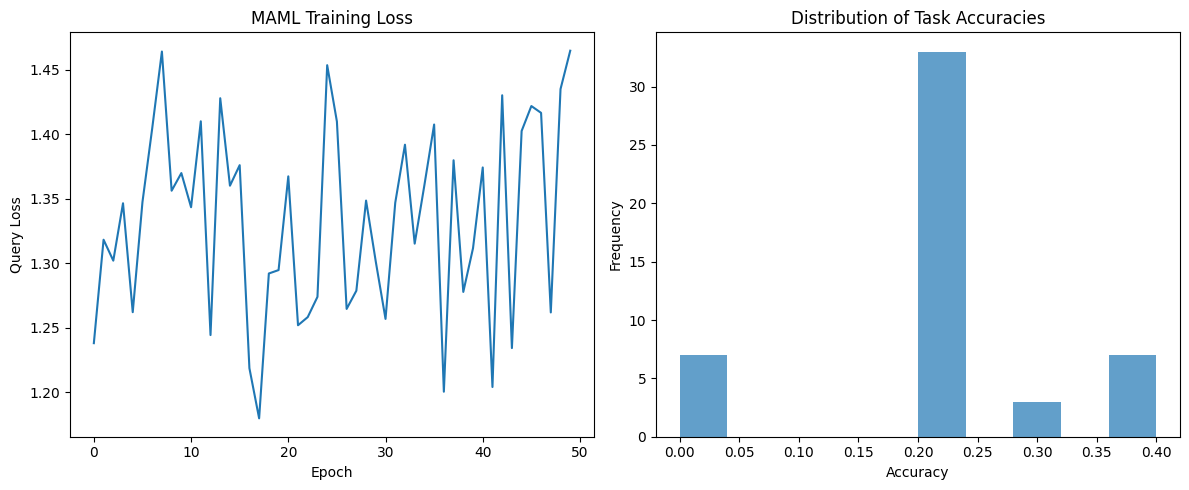

Final accuracy: 20.60%
Accuracy std: 10.85%
Min accuracy: 0.00%, Max: 40.00%


In [31]:
import torch
import higher

# instantiate a full model (encoder + linear head), train with existing train_maml, then evaluate few-shot accuracy
import torch.nn as nn
import torch.optim as optim

# build a model that maps encoder features to dataset-wide class logits
encoder = ConvNet()  # defined in earlier cell

# infer feature dim by a dummy forward
with torch.no_grad():
    dummy = torch.randn(1, 3, 84, 84)
    feat = encoder(dummy)
feature_dim = feat.view(1, -1).shape[1]

num_total_classes = len(full_dataset.classes)
class FewShotModel(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        feats = self.encoder(x)
        logits = self.classifier(feats)
        return logits

model = FewShotModel(encoder, feature_dim, num_total_classes)

# Re-instantiate task_sampler using the corrected FewShotTask class (defined in a later cell)
# This ensures we don't use an earlier buggy instance (which caused the sampling error).
task_sampler = FewShotTask(
    dataset=full_dataset,
    num_classes=5,
    num_support=1,
    num_query=2
)

# Train MAML (this will run on CPU to match data tensors as defined in train_maml)
train_epochs = 50
losses = train_maml(model, task_sampler, epochs=train_epochs, lr_inner=0.01, lr_meta=0.001)

# Evaluation: run a number of sampled tasks, perform inner adaptation on support set and measure query accuracy
def evaluate_maml(model, task_sampler, num_tasks=20, lr_inner=0.01):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    accs = []

    for _ in range(num_tasks):
        support_idxs, query_idxs = task_sampler.sample_task()
        support_imgs = torch.stack([full_dataset[i][0] for i in support_idxs])
        support_lbls = torch.tensor([full_dataset[i][1] for i in support_idxs])
        query_imgs = torch.stack([full_dataset[i][0] for i in query_idxs])
        query_lbls = torch.tensor([full_dataset[i][1] for i in query_idxs])

        # inner adaptation (one step) using higher
        with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=lr_inner), copy_initial_weights=False) as (fmodel, diffopt):
            support_preds = fmodel(support_imgs)
            support_loss = loss_fn(support_preds, support_lbls)
            diffopt.step(support_loss)

            query_preds = fmodel(query_imgs)
            preds = torch.argmax(query_preds, dim=1)
            acc = (preds == query_lbls).float().mean().item()
            accs.append(acc)

    avg_acc = float(np.mean(accs))
    print(f"Evaluation over {num_tasks} tasks: mean query accuracy = {avg_acc*100:.2f}%")
    return accs  # return list of accuracies

accs = evaluate_maml(model, task_sampler, num_tasks=50, lr_inner=0.01)
avg_acc = np.mean(accs)

# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Query Loss')
plt.title('MAML Training Loss')

plt.subplot(1, 2, 2)
plt.hist(accs, bins=10, alpha=0.7)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Task Accuracies')

plt.tight_layout()
plt.show()

print(f"Final accuracy: {avg_acc*100:.2f}%")
print(f"Accuracy std: {np.std(accs)*100:.2f}%")
print(f"Min accuracy: {min(accs)*100:.2f}%, Max: {max(accs)*100:.2f}%")

In [20]:
import torch

# save checkpoint
save_path = "maml_checkpoint.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'feature_dim': feature_dim,
    'num_classes': num_total_classes,
}, save_path)

# load checkpoint (later / in a new session)
ckpt = torch.load(save_path, map_location='cpu')
loaded_model = FewShotModel(ConvNet(), ckpt['feature_dim'], ckpt['num_classes'])
loaded_model.load_state_dict(ckpt['model_state_dict'])
loaded_model.eval()

FewShotModel(
  (encoder): ConvNet(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(32, eps=1e-05, mom